In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, confusion_matrix
import statsmodels.api as sm
from lifelines import KaplanMeierFitter

In [73]:
# Set up directories
outdir = r"C:\Users\tm1621\Desktop\Protein Project"
os.makedirs(outdir, exist_ok=True)

In [74]:
# 1. LOAD DATA FILES
maf_file = os.path.join(outdir, "cohortMAF.2025-05-25.maf")
clinical_file = r"C:\Users\tm1621\Desktop\Protein Project\clinical.cohort.2025-05-25\clinical.tsv"

maf = pd.read_csv(maf_file, sep="\t", comment="#", low_memory=False)
clinical = pd.read_csv(clinical_file, sep="\t", low_memory=False)

In [75]:
# 2. FEATURE AGGREGATION
drivers = ["KRAS", "TP53", "APC", "SMAD4"]
vc_types = ["Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins"]

In [76]:
# 2 & 3. FEATURE AGGREGATION  + CLEANING

# a) driver flags exactly like data.table::dcast
maf_drivers = maf[
    maf['Hugo_Symbol'].isin(drivers) &
    maf['Variant_Classification'].isin(vc_types)
]
flags = (
    maf_drivers
    .groupby(['Tumor_Sample_Barcode','Hugo_Symbol'])
    .size()
    .unstack(fill_value=0)                 # 0 = “no hits”
    .applymap(lambda x: 1 if x > 0 else 0) # turn counts→0/1
    .reset_index()
)

# b) tumor mutational burden
tmb = (
    maf[maf['Variant_Classification'].isin(vc_types)]
    .groupby('Tumor_Sample_Barcode')
    .size()
    .reset_index(name='Mutation_Count')
)

# c) sample IDs and merge
flags['Sample_ID'] = flags['Tumor_Sample_Barcode'].str[:12]
tmb  ['Sample_ID'] = tmb  ['Tumor_Sample_Barcode'].str[:12]

feature_table = (
    flags
    .merge(tmb, on=['Tumor_Sample_Barcode','Sample_ID'], how='outer')
    .merge(clinical,
           left_on='Sample_ID',
           right_on='cases.submitter_id',
           how='left')
)

# d) coerce age/followup → numeric
feature_table['Age']    = pd.to_numeric(feature_table['demographic.age_at_index'], errors='coerce')
feature_table['FollowUp'] = pd.to_numeric(feature_table['diagnoses.days_to_last_follow_up'], errors='coerce')

# e) **fill any missing flag** → 0
feature_table[drivers] = feature_table[drivers].fillna(0).astype(int)

# f) build model_data and drop ONLY on clinical cols
model_data = feature_table[
    [*drivers, 'Mutation_Count', 'Age',
     'diagnoses.ajcc_pathologic_stage',
     'demographic.vital_status',
     'FollowUp']
].copy()
model_data.columns = [
    'KRAS','TP53','APC','SMAD4','Mutation_Count','Age',
    'Stage','Outcome','FollowUp'
]

# drop rows missing Age, Stage, Outcome or FollowUp (driver flags are all 0/1 now)
model_data = model_data.dropna(subset=['Age','Stage','Outcome','FollowUp'])
model_data['Stage']   = model_data['Stage'].astype('category')
model_data['Outcome'] = model_data['Outcome'].astype('category')

# **Check your cleaned row‑count**:
print("Rows after cleaning:", model_data.shape[0])

C:\Users\tm1621\AppData\Local\Temp\ipykernel_31148\4057260166.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: 1 if x > 0 else 0) # turn counts→0/1


Rows after cleaning: 1798


Python and R did not reduce the model_data df in the same way, python reduced it to 1507 rows whilst R to 2501 rows (more or less)

In [77]:
# 4. TRAIN/TEST SPLIT
X = model_data.drop(['Outcome','FollowUp'], axis=1)
y = model_data['Outcome'].map({'Dead':1, 'Alive':0})
# One-hot encode Stage
dummies = pd.get_dummies(X['Stage'], drop_first=True)
X = pd.concat([X.drop('Stage',axis=1), dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234
)

In [78]:
# 5. LOGISTIC REGRESSION (statsmodels)

# 1) Build your design matrix
X_train_sm = sm.add_constant(X_train).astype(float)
y_train_sm = y_train.astype(float)

# 2) Replace any infinite values with NaN
X_train_sm = X_train_sm.replace([np.inf, -np.inf], np.nan)
#print("NaNs per column:\n", X_train_sm.isnull().sum())
#print("Infinite values per column:\n", np.isinf(X_train_sm).sum())

# 3) Drop any rows that contain NaN
mask = X_train_sm.notnull().all(axis=1)
X_train_sm = X_train_sm.loc[mask]
y_train_sm = y_train_sm.loc[mask]

# 4) Now fit
logit_model = sm.Logit(y_train_sm, X_train_sm).fit(disp=False)


c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


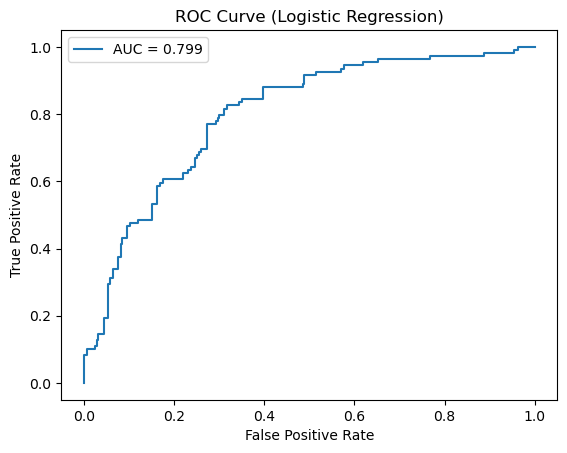

In [ ]:
# 6. ROC, CONFUSION, EXPORT
X_test_sm = sm.add_constant(X_test).astype(float)
pred_probs = logit_model.predict(X_test_sm)
fpr, tpr, _ = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig(os.path.join(outdir, 'ROC_logistic.png'))


In [80]:
pred_class = np.where(pred_probs > 0.5, 'Dead', 'Alive')
cm = confusion_matrix(y_test.map({1:'Dead',0:'Alive'}), pred_class, labels=['Alive','Dead'])
cm_df = pd.DataFrame(cm, index=['True_Alive','True_Dead'], columns=['Pred_Alive','Pred_Dead'])
cm_df.to_csv(os.path.join(outdir, 'ConfusionMatrix_logistic.csv'))

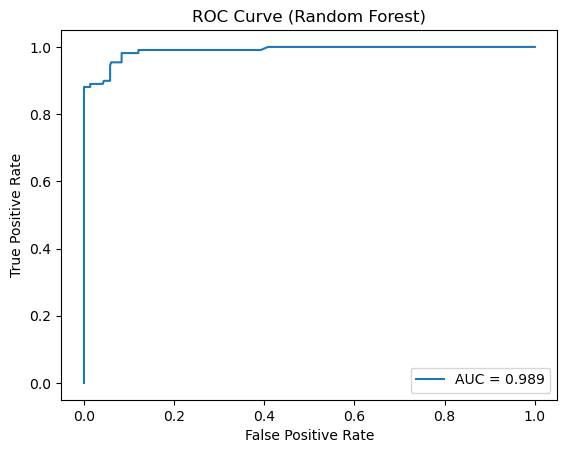

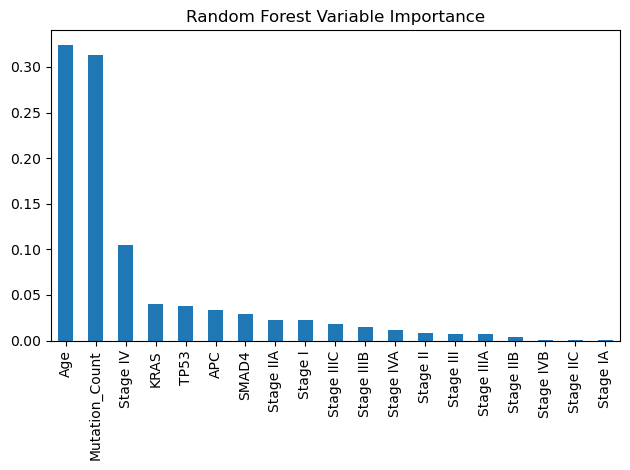

In [81]:
# 7. RANDOM FOREST
rf = RandomForestClassifier(n_estimators=500, random_state=1234,  oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)
plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f'AUC = {rf_auc:.3f}')
plt.title('ROC Curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig(os.path.join(outdir, 'ROC_randomforest.png'))
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
sorted_imp = importances.sort_values(ascending=False)
# -------------------------------
# -------------------------------
plt.figure()
sorted_imp.plot.bar()
plt.title('Random Forest Variable Importance')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'RF_VariableImportance.png'))

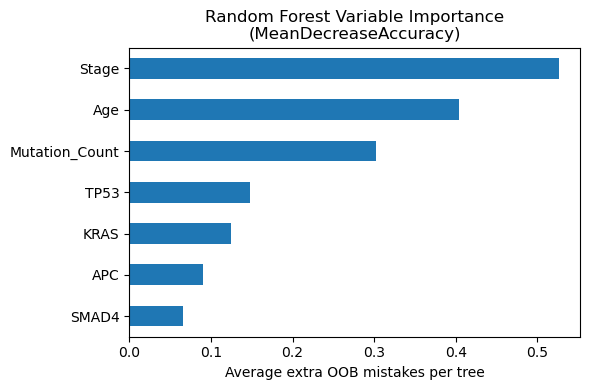

In [82]:
perm = permutation_importance(rf,  X_train,  y_train, n_repeats=1, random_state=1234, scoring="accuracy" )                                      # use the training data                

n_train = len(X_train)
n_trees = rf.n_estimators

# perm.importances_mean is the average drop-in-accuracy across the whole forest
# *n_train gives total extra mistakes across all trees
# /n_trees gives the per-tree average, just like R
misclass_per_tree = perm.importances_mean * n_train / n_trees

imp = pd.Series(misclass_per_tree, index=X_train.columns)

# collapse Stage_* into “Stage”
imp_agg = (imp
           .groupby(lambda f: "Stage" if f.startswith("Stage") else f)
           .sum()
           .sort_values())

ax = imp_agg.plot.barh(figsize=(6,4))
ax.set_title("Random Forest Variable Importance\n(MeanDecreaseAccuracy)")
ax.set_xlabel("Average extra OOB mistakes per tree")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "RF_MeanDecreaseAccuracy_per_tree.png"))


Text(0.5, 0, 'Total Gini decrease (sum of impurity drops across all trees)')

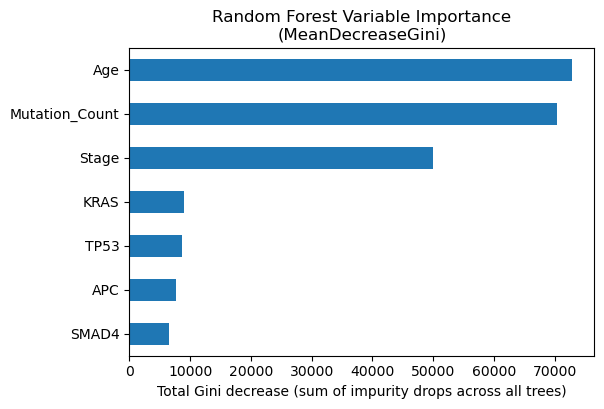

In [83]:
raw_gini = pd.Series(0.0, index=X_train.columns)
for tree in rf.estimators_:
    imp  = tree.tree_.impurity
    ns   = tree.tree_.weighted_n_node_samples
    feat = tree.tree_.feature
    left = tree.tree_.children_left
    right= tree.tree_.children_right

    # for each internal node i, the “drop” is
    #    (imp_i - imp_left)*ns_left  +  (imp_i - imp_right)*ns_right
    for i in range(tree.tree_.node_count):
        f = feat[i]
        if f >= 0:
            dl = (imp[i] - imp[left[i]]) * ns[left[i]]
            dr = (imp[i] - imp[right[i]])* ns[right[i]]
            raw_gini[X_train.columns[f]] += (dl+dr)

gini_agg = (raw_gini
             .groupby(lambda c: 'Stage' if c.startswith('Stage') else c)
             .sum()
             .sort_values())

ax = gini_agg.plot.barh(figsize=(6,4))
ax.set_title('Random Forest Variable Importance\n(MeanDecreaseGini)')
ax.set_xlabel('Total Gini decrease (sum of impurity drops across all trees)')


In [84]:
# Set up directories
outdir = r"C:\Users\tm1621\Desktop\Protein Project"
os.makedirs(outdir, exist_ok=True)

In [85]:
# 1. LOAD DATA FILES
maf_file = os.path.join(outdir, "cohortMAF.2025-05-25.maf")
clinical_file = r"C:\Users\tm1621\Desktop\Protein Project\clinical.cohort.2025-05-25\clinical.tsv"

maf = pd.read_csv(maf_file, sep="\t", comment="#", low_memory=False)
clinical = pd.read_csv(clinical_file, sep="\t", low_memory=False)

In [86]:
# 2. FEATURE AGGREGATION
drivers = ["KRAS", "TP53", "APC", "SMAD4"]
vc_types = ["Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins"]

# Flags for driver mutations
maf_drivers = maf[maf['Hugo_Symbol'].isin(drivers) & maf['Variant_Classification'].isin(vc_types)]
flags = (
    maf_drivers
    .groupby(['Tumor_Sample_Barcode', 'Hugo_Symbol'])
    .size()
    .unstack(fill_value=0)
    .map(lambda x: 1 if x > 0 else 0)
    .reset_index()
)
# Tumor mutational burden
tmb = (
    maf[maf['Variant_Classification'].isin(vc_types)]
    .groupby('Tumor_Sample_Barcode')
    .size()
    .reset_index(name='Mutation_Count')
)
# Add Sample_ID (first 12 chars)
flags['Sample_ID'] = flags['Tumor_Sample_Barcode'].str[:12]
tmb['Sample_ID'] = tmb['Tumor_Sample_Barcode'].str[:12]

# Merge and join clinical
feature_table = pd.merge(flags, tmb, on=['Tumor_Sample_Barcode','Sample_ID'], how='outer')
feature_table = pd.merge(
    feature_table,
    clinical,
    left_on='Sample_ID',
    right_on='cases.submitter_id',
    how='left'
)

In [87]:
# 3. SELECT, CLEAN, FORMAT
feature_table['Age'] = pd.to_numeric(feature_table['demographic.age_at_index'], errors='coerce')
model_data = feature_table[[*drivers, 'Mutation_Count', 'Age',
                            'diagnoses.ajcc_pathologic_stage',
                            'demographic.vital_status',
                            'diagnoses.days_to_last_follow_up']].copy()
model_data.columns = [
    'KRAS','TP53','APC','SMAD4','Mutation_Count','Age',
    'Stage','Outcome','FollowUp'
]
# Ensure FollowUp is numeric and drop invalid entries
model_data['FollowUp'] = pd.to_numeric(model_data['FollowUp'], errors='coerce')
model_data = model_data.dropna(subset=[*drivers, 'Mutation_Count','Age','Stage','Outcome','FollowUp'])
model_data['Stage'] = model_data['Stage'].astype('category')
model_data['Outcome'] = model_data['Outcome'].astype('category')

In [88]:
# 4. TRAIN/TEST SPLIT
X = model_data.drop(['Outcome','FollowUp'], axis=1)
y = model_data['Outcome'].map({'Dead':1, 'Alive':0})
# One-hot encode Stage
dummies = pd.get_dummies(X['Stage'], drop_first=True)
X = pd.concat([X.drop('Stage',axis=1), dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234
)

In [89]:
# 5. LOGISTIC REGRESSION (statsmodels)
# Add constant and ensure numeric types
X_train_sm = sm.add_constant(X_train).astype(float)
y_train_sm = y_train.astype(float)
# Fit model
logit_model = sm.Logit(y_train_sm, X_train_sm).fit(disp=False)
conf = logit_model.conf_int()
exp_coef = pd.DataFrame({
    'OR': np.exp(logit_model.params),
    'CI_lower': np.exp(conf[0]),
    'CI_upper': np.exp(conf[1])
})
exp_coef.to_csv(os.path.join(outdir, 'Logistic_ORs.csv'))

c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tm1621\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


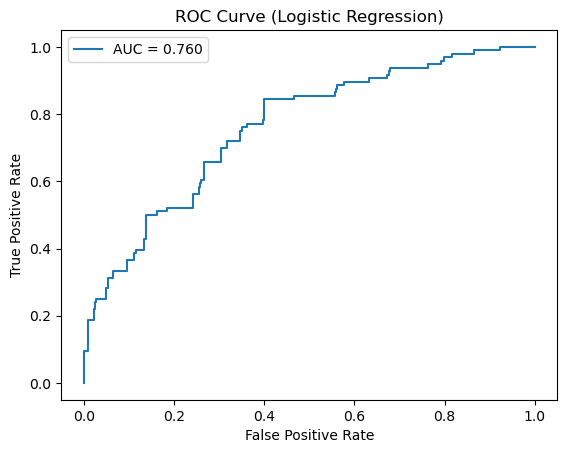

In [90]:
# 6. ROC, CONFUSION, EXPORT
X_test_sm = sm.add_constant(X_test).astype(float)
pred_probs = logit_model.predict(X_test_sm)
fpr, tpr, _ = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig(os.path.join(outdir, 'ROC_logistic.png'))


In [91]:
pred_class = np.where(pred_probs > 0.5, 'Dead', 'Alive')
cm = confusion_matrix(y_test.map({1:'Dead',0:'Alive'}), pred_class, labels=['Alive','Dead'])
cm_df = pd.DataFrame(cm, index=['True_Alive','True_Dead'], columns=['Pred_Alive','Pred_Dead'])
cm_df.to_csv(os.path.join(outdir, 'ConfusionMatrix_logistic.csv'))

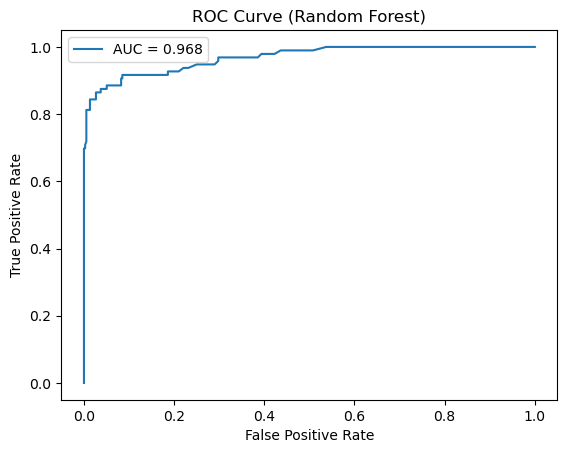

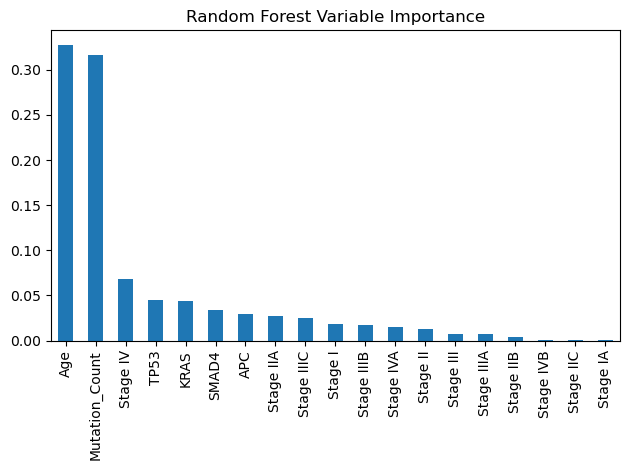

In [92]:
# 7. RANDOM FOREST
rf = RandomForestClassifier(n_estimators=500, random_state=1234)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)
plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f'AUC = {rf_auc:.3f}')
plt.title('ROC Curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig(os.path.join(outdir, 'ROC_randomforest.png'))
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
sorted_imp = importances.sort_values(ascending=False)
# -------------------------------
# -------------------------------
plt.figure()
sorted_imp.plot.bar()
plt.title('Random Forest Variable Importance')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'RF_VariableImportance.png'))

Text(0.5, 0, 'Average extra OOB mistakes per tree')

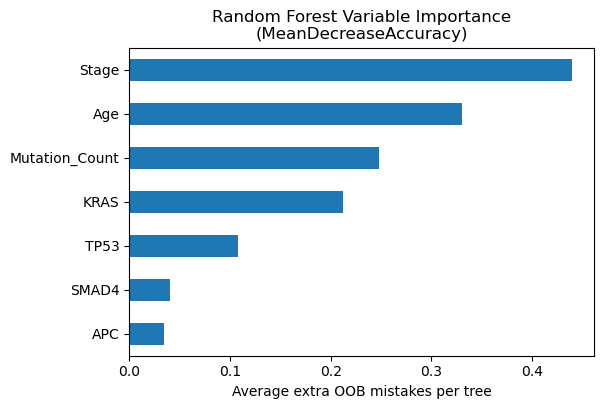

In [93]:
perm = permutation_importance(rf, X_train, y_train,
                              n_repeats=1, random_state=1234,
                              scoring="accuracy")
# perm.importances_mean is the drop-in-accuracy fraction across the *entire* training set
# Multiply by n_train to get raw extra mistakes,
# then divide by n_estimators to get average *per tree* (like R’s)
n_train = len(X_train)
perm_counts_per_tree = (perm.importances_mean * n_train) / rf.n_estimators

# Aggregate Stage dummies and plot:
perm_agg = (pd.Series(perm_counts_per_tree, index=X_train.columns)
              .groupby(lambda c: 'Stage' if c.startswith('Stage') else c)
              .sum()
              .sort_values())

ax = perm_agg.plot.barh(figsize=(6,4))
ax.set_title('Random Forest Variable Importance\n(MeanDecreaseAccuracy)')
ax.set_xlabel('Average extra OOB mistakes per tree')


In [94]:
# 8. RISK STRATIFICATION
test_df = X_test.copy()
test_df['risk_score'] = pred_probs
test_df['risk_group'] = pd.qcut(test_df['risk_score'], q=[0,0.33,0.66,1.0], labels=['Low','Medium','High'])
test_df['Outcome'] = y_test.map({1:'Dead',0:'Alive'})
test_df['FollowUp'] = model_data.loc[X_test.index, 'FollowUp']

# Coerce FollowUp in test_df to float and drop any non-numerics
test_df['FollowUp'] = pd.to_numeric(test_df['FollowUp'], errors='coerce').astype(float)

# Remove rows where FollowUp is NaN or infinite
test_df = test_df[np.isfinite(test_df['FollowUp'])]

Events (deaths): 96
Median follow-up (days): 761.0


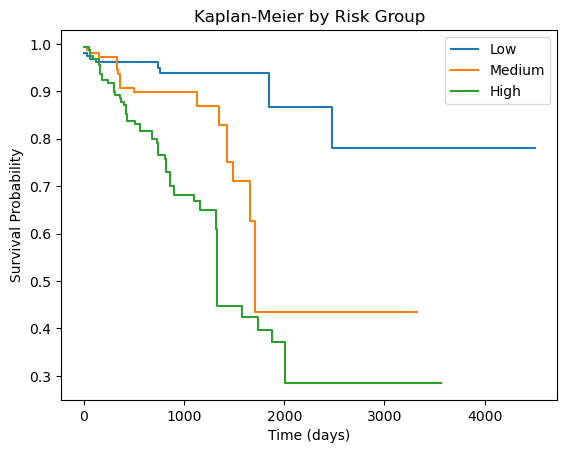

In [95]:
# 9. SURVIVAL ANALYSIS
kmf = KaplanMeierFitter()
plt.figure()
for grp in ['Low','Medium','High']:
    mask = test_df['risk_group'] == grp
    kmf.fit(durations=test_df.loc[mask,'FollowUp'], event_observed=(test_df.loc[mask,'Outcome']=='Dead'), label=grp)
    kmf.plot_survival_function(ci_show=False)
plt.title('Kaplan-Meier by Risk Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.savefig(os.path.join(outdir, 'KM_risk_stratification.png'))

# Summary stats
events = (test_df['Outcome']=='Dead').sum()
median_follow = test_df['FollowUp'].median()
print(f"Events (deaths): {events}")
print(f"Median follow-up (days): {median_follow}")

In [96]:
# 10. EXPORT MAJOR TABLES
coef_df = pd.DataFrame({'variable': logit_model.params.index, 'coef': logit_model.params.values})
coef_df.to_csv(os.path.join(outdir, 'Model_coefficients_for_EMR.csv'), index=False)
table1 = (
    model_data
    .groupby('Outcome')
    .agg(n=('Age','count'), Age_mean=('Age','mean'), Mutation_Count_mean=('Mutation_Count','mean'), KRAS_mut=('KRAS','mean'), TP53_mut=('TP53','mean'), APC_mut=('APC','mean'), SMAD4_mut=('SMAD4','mean'))
    .reset_index()
)
table1.to_csv(os.path.join(outdir, 'Table1_Baseline.csv'), index=False)
df_clean = model_data.copy()
df_clean.to_csv(os.path.join(outdir, 'model_data_cleaned.csv'), index=False)

C:\Users\tm1621\AppData\Local\Temp\ipykernel_31148\2053186562.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Outcome')
